# Assignment 7: Bagging and Boosting

Only use the already imported library `numpy`, `matplotlib` and the Python standard library. For the evaluation you may also use scikit-learn (`sklearn`). Make sure that the dataset `titanic.csv` is in the same directory as the notebook.

List your team members (name and immatriculation number) and indicate whether you are a B.Sc. Data Science or other group in the following cell:

- *Your names here*

In [386]:
# You are allowed to use the numpy package and the DecisionTreeClassifier.
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier


def load_dataset(path):
    import pandas as pd
    from sklearn.model_selection import train_test_split

    df = pd.read_csv('titanic.csv')
    # The feature engineering mostly follows the notebook by Manav Segal: https://www.kaggle.com/startupsci/titanic-data-science-solutions
    # From the Name attribute we can extract titles, which gives insight about the social status/age/gender of the passenger.
    df['Title'] = df['Name'].str.extract(' ([a-zA-Z]+)\.', expand=False)
    df['Title'] = df['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    # We map the Title attribute to a one-hot encoding.
    df = df.join(pd.get_dummies(df['Title'], prefix='Title'))

    # We map the Sex attribute to a numeric representation.
    df['Sex'] = df['Sex'].map({'female': 1, 'male': 0}).astype(int)

    # We one-hot encode Pclass.
    df = df.join(pd.get_dummies(df['Pclass'], prefix='Pclass'))

    # Based on the number of sibling-spouses in SibSp and parents-childern in Parch, 
    # we can determine whether a passenger was on board alone.
    df['IsAlone'] = ((df['SibSp'] + df['Parch'] + 1) == 1).astype(int)

    # We remove all attributes that do not seem relevant to the prediction, or are already encoded in another attribute.
    df = df.drop(['PassengerId', 'Name', 'Title', 'Ticket', 'Cabin', 'Parch', 'SibSp'], axis=1)

    # For remaining features, we have to separate train and test, 
    # as we will impute missing data based on statistics in the training data.
    df_train, df_test = train_test_split(df, test_size=0.2, random_state=2020)
    # For Embarked, we set all missing values to the most frequent port and then one-hot encode the attribute.
    def impute_embarked():    
        freq_port = df_train['Embarked'].dropna().mode()[0]
        output = []
        for df in (df_train, df_test):
            df = df.join(pd.get_dummies(df['Embarked'].fillna(freq_port), prefix='Embarked'))
            df = df.drop('Embarked', axis=1)
            output.append(df)
        return output

    df_train, df_test = impute_embarked()

    # For Age, we set missing values to the median dependent on the pair of Sex and Pclass.
    guess_ages = np.zeros((2, 3))
    for df in (df_train, df_test):
        for i in range(2):
            for j in range(3):
                guess_ages[i, j] = df[(df['Sex'] == i) & (df['Pclass'] == j+1)]['Age'].dropna().median()
        for i in range(2):
            for j in range(3):
                df.loc[(df['Age'].isnull()) & (df['Sex'] == i) & (df['Pclass'] == j+1), 'Age'] = guess_ages[i, j]
        df['Age'] = df['Age'].astype(int)

    df_train = df_train.drop(['Pclass'], axis=1)
    df_test = df_test.drop(['Pclass'], axis=1)

    X_train = df_train.values[:, 1:]
    X_test = df_test.values[:, 1:]
    y_train = df_train.values[:, 0]
    y_test = df_test.values[:, 0]
    
    return X_train, X_test, y_train, y_test
    
X_train, X_test, y_train, y_test = load_dataset('titanic.csv')

The Titanic dataset and a description can be found at [Kaggle](https://www.kaggle.com/c/titanic/data). The feature engineering mostly follows the work by [Manav Segal](https://www.kaggle.com/startupsci/titanic-data-science-solutions). 

The prepared dataset contains the following attributes:
- Sex: binary (0 = Male, 1 = Female)
- Age: integer
- Fare: float
- Title_{Master, Miss, Mr, Mrs, Rare}: title of passenger (extracted from name), binary, one-hot encoding of categorical variable Title
- Pclass_{1, 2, 3}: ticket class corresponds to socio-economic status (1 = upper class, 2 = middle class, 3 = lower class), binary, one-hot encoding of categorical variable Pclass
- IsAlone: whether the passenger has no siblings/spouses/parents/children on board, binary
- Embarked_{C, Q, S}: port at which passenger embarked (C = Cherbourg, Q = Queenstown, S = Southampton), binary, one-hot encoding of categorical variable Embarked

The classification target is:
- Survived: binary

Data is split into train-test with a 80-20 ratio yielding 712 training and 179 test samples. Train and test data is stored in the variables `(X_train, y_train)` and `(X_test, y_test)` respectively.

## Task 1: Random Forest

In this task, you will implement a random forest classifier using the scikit-learn implementation of the decision tree. 

Use bootstrap sampling and sample 20% of the original data set for each tree. Randomly select 6 attributes/columns for each trained tree. The prediction of each tree should be weighted equally in the majority vote. Use the already imported class `DecisionTreeClassifier` for your decision trees. You can find the decision tree documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). You may use either the default parameters or experiment with different settings.

You will evaluate your model on the test data using scikit-learn with the methods shown in the lecture ([precision, recall, F1-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support), [confusion matrices](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html?highlight=confusion%20matrix#sklearn.metrics.confusion_matrix), ...). Try out different number of trees and compare the performance w.r.t. this parameter. Feel free to import any functions you need from scikit-learn for this purpose. 


In [387]:
class RandomForestClassifier(object):
    def __init__(self, number_of_trees):
        self.number_of_trees = number_of_trees
        self.trees = []
        self.tree_features = []
        for i in range(self.number_of_trees):
            self.trees.append(DecisionTreeClassifier())      
     
        
    def fit(self, X, y): 

        for tree in self.trees:
            X_sample, y_sample = bootstrap_sample(X, y)
            columns = sorted(np.random.choice(range(np.size(X,1)), replace=False, size=6))            
            self.tree_features.append(columns)
            tree.fit(X_sample[:,columns], y_sample)             
        
    
    def predict(self, X):
        y = [0 for i in range(np.size(X,0))]
        for tree, columns in zip(self.trees, self.tree_features):
            y = y + tree.predict(X[:,columns])       

        # Since labels are binary (0,1) we simply added all prediction of the trees 
        # If the resulting value is smaller than tree_number / 2 majority is 0 else 1
        y_pred = [(0 if i < (self.number_of_trees/2) else 1) for i in y]        
        return y_pred

def bootstrap_sample(X, y):    
    index = np.random.choice(range(np.size(X,0)), replace=False, size=(np.size(X,0)/100)*20)     
    X_sample = X[index,:]
    y_sample = y[index]    
    return X_sample, y_sample


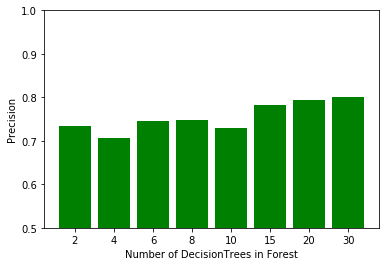

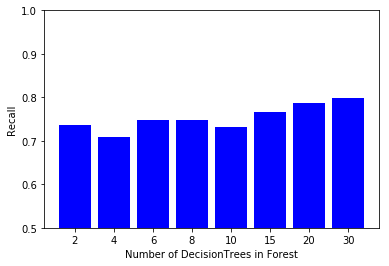

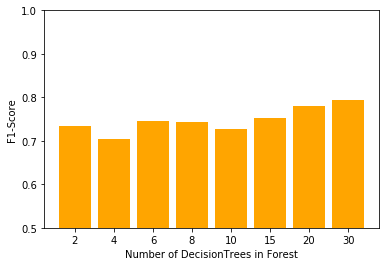

In [388]:
# Implement your training and evaluation here.
def evaluate(rf_classifier, X, y_true):

    import sklearn.metrics      
    y_pred = rf_classifier.predict(X) 
    prec,rec,f1,_ = sklearn.metrics.precision_recall_fscore_support(y_true, y_pred)
    acc = sklearn.metrics.accuracy_score(y_true,y_pred)    
   
    
    return prec,rec,f1,acc

def visualize_results(results, tree_count):
    x_ticks = np.arange(len(tree_count)) 
      
    # precision
    data = [(x[0][0] * label_weights[0] + x[0][1] * label_weights[1])/sample_size  for x in results]
    plt.xticks(x_ticks, tree_count)
    plt.bar(x_ticks, data, color='green')
    plt.xlabel("Number of DecisionTrees in Forest")
    plt.ylabel("Precision")    
    plt.ylim(0.5,1)
    plt.show()
    plt.close()
    # recall
    data = [(x[1][0] * label_weights[0] + x[1][1] * label_weights[1])/sample_size  for x in results]
    plt.xticks(x_ticks, tree_count)
    plt.bar(x_ticks, data, color='blue')
    plt.xlabel("Number of DecisionTrees in Forest")
    plt.ylabel("Recall")
    plt.ylim(0.5,1)    
    plt.show()
    plt.close()
    #f1-score
    data = [(x[2][0] * label_weights[0] + x[2][1] * label_weights[1])/sample_size  for x in results]
    plt.xticks(x_ticks, tree_count)
    plt.bar(x_ticks, data, color='orange')
    plt.xlabel("Number of DecisionTrees in Forest")
    plt.ylabel("F1-Score")  
    plt.ylim(0.5,1)  
    plt.show()
    plt.close()    

results = []
label_weights = np.bincount(list(y_test))
sample_size = np.size(y_test)
tree_count = [2,4,6,8,10,15,20,30]
for tree in tree_count:
    rf_class = RandomForestClassifier(tree)
    rf_class.fit(X_train, y_train)
    prec, rec, f1, acc = evaluate(rf_class, X_test, y_test)
    results.append([prec, rec, f1, acc])
visualize_results(results,tree_count)   
    











## Task 2: Interpreting Random Forests

Implement the mean decrease of accuracy for the [sklearn.ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) `forest` to analyse learned attribute importances. Use the test set `X_test` and `y_test` as out-of-bag-samples. Permute the values of the assessed attribute by randomly shuffling the corresponding column. Plot the results to compare the importance of each feature. Discuss your results (are any importance values surprising, do the results make sense in the context of the task, ...).

Note: We have already trained the classifier and stored it in the variable `forest`. You only need to implement MDA and the plots for your results.

In [389]:
def create_forest():
    import sklearn.ensemble
    import sklearn.metrics
    forest = sklearn.ensemble.RandomForestClassifier(8)
    forest.fit(X_train, y_train)
    prec, rec, f1, _ = sklearn.metrics.precision_recall_fscore_support(y_test, forest.predict(X_test))
    print('Precision:', prec)
    print('Recall:', rec)
    print('F1-score:', f1)
    return forest

forest = create_forest()

('Precision:', array([0.76271186, 0.75409836]))
('Recall:', array([0.85714286, 0.62162162]))
('F1-score:', array([0.80717489, 0.68148148]))


In [390]:
# Implement your solution here.

## Task 3: Discrete AdaBoost with Decision Stumps
 
*For all students other than B.Sc. Data Science.*  

In this task, you will implement the discrete AdaBoost algorithm using decision stumps as weak learners. Your training will run until either `n_learners` weak learners have been added or a perfect accuracy on the training data set is achieved. Use the function `initialize_decision_stumps` to create decision stumps, which you can train on your weighted data using `fit` and predict using `predict`. The decision stumps are instances of the class [sklearn.tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

In addition, you will evaluate your model on the test data (`X_test`, `y_test`) using scikit-learn with the methods shown in the lecture (precision, recall, F1-score, confusion matrices, ...). Feel free to import any functions you need from scikit-learn for this purpose.

In [391]:
def initialize_decision_stump():
    stump = DecisionTreeClassifier(criterion='entropy', max_depth=1)
    return stump


class AdaBoostClassifier(object):
    def __init__(self, n_learners):
        self.n_learners = n_learners
        # Add any initialization you need here.
    
    def fit(self, X, y):
        # Implement your solution here.
        pass
    
    def predict(self, X, y):
        # Implement your solution here.
        pass


In [392]:
# Implement your training and evaluation here. You may reuse the code from Task 1.